## Vectorization

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

### 1. Load Data

#### Open-ended Answers

In [2]:
quantity_learning = pd.read_csv('./data/quantity_learning.csv')

In [3]:
radio_lessons = pd.read_csv('./data/radio_lessons.csv')

## 2. Count vectorization function
#### 2.1. Retrieve bi/trigrams tokens, refine and encode

In [4]:
stopwords = stopwords.words('english')

In [5]:
def removal(text):
    text = re.sub(r'(\d|\$|\%|\+)', '', text.lower())
    return re.sub(r'\d+', '', text)

In [6]:
def bow_vectorization(data, index, n_grams):
    vectorizer = CountVectorizer(stop_words = stopwords, lowercase = True, strip_accents='unicode', ngram_range=n_grams, preprocessor=removal)
    data_tokens = vectorizer.fit_transform(data)
    print(len(vectorizer.vocabulary_),'words in dictionary.')
    return pd.DataFrame(data_tokens.todense(), columns=vectorizer.get_feature_names(), index=index)

#### 2.2. Search word in vocabulary

In [7]:
def search(word_in=None, word_out=None, vocabulary=None):
    if word_in is None:
        return 'no words to search'

    words = []
    if isinstance(word_in, list):
        for word in word_in:
            for term in vocabulary:
                if word in term:
                    words.append(term)            
    else:
        for term in vocabulary:
            if word_in in term:
                words.append(term)
    
    words_clean = []
    if word_out:
        if isinstance(word_out,str):
            word_out = [word_out]
        for word in word_out:
            for term in words:
                if word in term:
                    pass
                else:
                    words_clean.append(term)
        return words_clean
    else:
        return words

## 3. Questions to vectorize

### 3.4. Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures? Why?

In [8]:
quantity_learning.iloc[:,1].value_counts()

Less        1249
More          80
The same      46
Name: Q52_Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures?, dtype: int64

Get only 'Less' answers

In [9]:
quantity_learning_less = quantity_learning[quantity_learning.iloc[:,1] == 'Less'].iloc[:,2]

In [10]:
quantity_learning[quantity_learning.iloc[:,1] == 'Less'].iloc[:,2].tolist()[:10]

['Because radios are not many in our area',
 'Because of power for charging radio',
 'Because of COVID_19',
 'Due to restrictions by the Covid 19 ',
 'Because of Covid 19 restrictions ',
 'Some teachers in radio lesson use complicated language hard to understand',
 "I don't know",
 'Rodio it is not enough',
 'Teaching is past',
 'Teaching is past in during the lesson']

#### Trigram vectorization
Learning Less with radio lessons after covid

In [11]:
quantity_learning_less_tri = bow_vectorization(data = quantity_learning_less.dropna(), 
                                               index = quantity_learning_less.dropna().index,
                                               n_grams=(3, 3))

1195 words in dictionary.


In [12]:
#quantity_learning_less_tri.sum().sort_values(ascending=False)[:60]

#### Group Trigrams
Trigrams about work

In [13]:
domestic_work = search(['domestic','garden'], None, quantity_learning_less_tri.columns)
len(domestic_work)

57

In [14]:
out_work = search('work', ['domestic','home','house','garden'], quantity_learning_less_tri.columns)
len(out_work)

336

In [15]:
activities = search('activities', 'less', quantity_learning_less_tri.columns)
len(activities)

23

Trigrams about time

In [16]:
time = search('time', None, quantity_learning_less_tri.columns)
len(time)

229

In [17]:
less = search('less', None, quantity_learning_less_tri.columns)
len(less)

189

In [18]:
lack = search('lack', None, quantity_learning_less_tri.columns)
len(lack)

22

Trigrams about education

In [19]:
education = search(['teacher','underst'], None, quantity_learning_less_tri.columns)
len(education)

90

Trigrams about radio

In [20]:
radio = search(['radio','acces','cove'], None, quantity_learning_less_tri.columns)
len(radio)

324

Count one per concept apperance (not word)

In [21]:
domestic_w = quantity_learning_less_tri[domestic_work]

In [22]:
ex_work = quantity_learning_less_tri[list(set(out_work + activities))]

In [23]:
time = quantity_learning_less_tri[list(set(time + less + lack))]

In [24]:
ed = quantity_learning_less_tri[education]

In [25]:
get_radio = quantity_learning_less_tri[radio]

The rest of the Bigrams

In [26]:
other = quantity_learning_less_tri.drop(domestic_w.columns.to_list() + \
                               ex_work.columns.to_list() + \
                               time.columns.to_list() + \
                               ed.columns.to_list() + \
                               get_radio.columns.to_list(), axis=1)
test_other = quantity_learning_less_tri.drop(domestic_w.columns.to_list() + \
                               ex_work.columns.to_list() + \
                               time.columns.to_list() + \
                               ed.columns.to_list() + \
                               get_radio.columns.to_list(), axis=1)

In [27]:
domestic_w = domestic_w.sum(axis=1)
ex_work = ex_work.sum(axis=1)
time = time.sum(axis=1)
ed = ed.sum(axis=1)
other = other.sum(axis=1)

In [28]:
domestic_w[domestic_w != 0] = 1
ex_work[ex_work != 0] = 1
time[time != 0] = 1
ed[ed != 0] = 1
other[other != 0] = 1

In [29]:
domestic = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['domestic work'])
domestic.loc[domestic_w[domestic_w == 1].index,:] = 1
work = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['external work'])
work.loc[ex_work[ex_work == 1].index,:] = 1
no_time = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['no time'])
no_time.loc[time[time == 1].index,:] = 1
no_ed = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['less education'])
no_ed.loc[ed[ed == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['other triagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [30]:
quantity_learning_less_group = pd.concat([domestic, work, no_time, no_ed, other_w], axis=1)
quantity_learning_less_group_2= pd.concat([domestic, work, no_time, no_ed], axis=1)

In [31]:
labels = quantity_learning_less_group_2.columns.to_list()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=quantity_learning_less_group_2.sum().to_list(),
    text=quantity_learning_less_group_2.sum().to_list(),
    texttemplate='%{text}',
    textposition="outside",
    textangle=0,
    textfont_color="black",
))

fig.update_traces(textfont_size=18)
fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                      font=dict(
                        size=18,
                    ),
                  title_text='Are you/your learners learning more or are you learning less<br>using radio lessons since the COVID-19 school closures? <b>Why less?</b>')
pio.write_image(fig, 'plotly/learning_quant_less.jpg', width=1024, height=780)

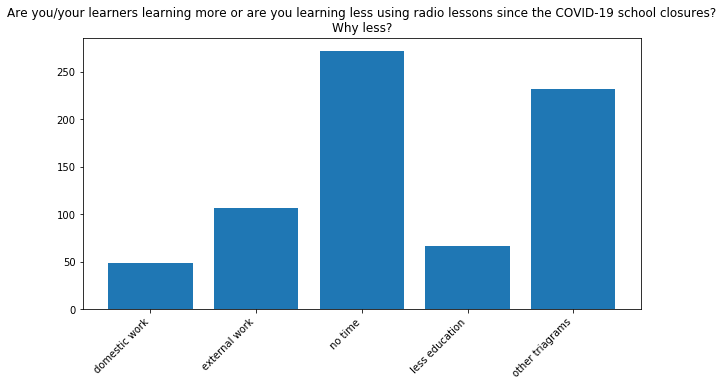

In [32]:
plt.figure(figsize=(10,5))
plt.bar(quantity_learning_less_group.columns, quantity_learning_less_group.sum())
plt.title('Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures?\nWhy less?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/learning_quant_less.jpeg',bbox_inches='tight', dpi=300)
plt.show()

In [33]:
quantity_learning_less_group.loc[:,'domestic work'].sum() / quantity_learning_less.shape[0]

0.03923138510808647

In [34]:
quantity_learning_less_group.loc[:,'external work'].sum() / quantity_learning_less.shape[0]

0.08566853482786228

In [35]:
quantity_learning_less_group.loc[:,'no time'].sum() / quantity_learning_less.shape[0]

0.2177742193755004

In [36]:
quantity_learning_less_group.loc[:,'less education'].sum() / quantity_learning_less.shape[0]

0.053642914331465175

#### Save vectors and concepts

In [37]:
# tokens
quantity_learning_less_tri.to_csv('data/tokens/quantity_learning_less_yes.csv')
# concepts
quantity_learning_less_group.to_csv('data/concepts/quantity_learning_less_concepts.csv')

### 3.5. What is the quality of the radio lessons? How can the radio lessons be improved?

In [38]:
radio_lessons.notnull().sum()

Unnamed: 0                                        4727
Q57_What is the quality of the radio lessons?     1375
Q58_How can the radio lessons be improved?        1375
dtype: int64

In [39]:
radio_lessons.iloc[:,1].value_counts()

Good         644
Fair         396
Not good     186
Very good    149
Name: Q57_What is the quality of the radio lessons? , dtype: int64

Don't Know

In [40]:
dk_mask = radio_lessons.iloc[:,2].str.contains("don't know", na=False) | \
              radio_lessons.iloc[:,2].str.contains("no know", na=False) | \
              (radio_lessons.iloc[:,2].str.contains("idea", na=False)) | \
              (radio_lessons.iloc[:,2].str.contains("nothing", na=False))

In [41]:
# radio_lessons[dk_mask].iloc[:,2].value_counts()

Group 'Good' with 'Very Good' and 'Not good' with 'Fair'

In [42]:
# fair + not good vs 
radio_lessons_good = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Good')].iloc[:,2]

In [43]:
radio_lessons_fair = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Fair')].iloc[:,2]

In [44]:
radio_lessons_vgood = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Very good')].iloc[:,2]

In [45]:
radio_lessons_ngood = radio_lessons[~dk_mask & (radio_lessons.iloc[:,1] == 'Not good')].iloc[:,2]

#### Trigram Vectorization
Radio Lessons Good Quality

In [46]:
radio_lessons_good_tri = bow_vectorization(data = radio_lessons_good.dropna(),
                                          index = radio_lessons_good.dropna().index,
                                          n_grams=(3, 3))

1138 words in dictionary.


In [47]:
#radio_lessons_good_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [48]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'provis', radio_lessons_good_tri.columns)
print(len(coverage_1))

222


In [49]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'exten', radio_lessons_good_tri.columns)
print(len(coverage_2))

199


In [50]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'avail', radio_lessons_good_tri.columns)
print(len(coverage_3))

236


In [51]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power','local'], \
                  'local', radio_lessons_good_tri.columns)
print(len(coverage_4))

204


In [52]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

199

Trigrams about the provision of radios

In [53]:
power = search(['powe','energ'],None, radio_lessons_good_tri.columns)
len(power)

27

In [54]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_good_tri.columns)
len(provision)

160

In [55]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_good_tri.columns)
len(tv)

12

Trigrams about content

In [56]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_good_tri.columns)
len(content)

224

Trigrams about speech

In [57]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_good_tri.columns)
len(language)

36

In [58]:
speed = search(['speed','unders'], None, radio_lessons_good_tri.columns)
len(speed)

27

Trigrams about teaching

In [59]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_good_tri.columns)
len(teaching)

172

Tigrams about school re-opening

In [60]:
school = search(['reopen', 'open'], None, radio_lessons_good_tri.columns)
len(school)

19

Tigrams about time (to listen, of broadcast)

In [61]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_good_tri.columns)
len(time)

202

In [62]:
len(list(set(language +  speed + teaching)))

194

Count one per concept apperance (not word)

In [63]:
cover = radio_lessons_good_tri[coverage]

In [64]:
r_provision = radio_lessons_good_tri[list(set(power + provision + tv))]

In [65]:
l_content = radio_lessons_good_tri[content]

In [66]:
#teach = radio_lessons_good_tri[teaching]

In [67]:
r_time = radio_lessons_good_tri[time]

In [68]:
#l_speech = radio_lessons_good_tri[list(set(language +  speed))]

In [69]:
guidance = radio_lessons_good_tri[list(set(language +  speed + teaching))]

The rest of the Trigrams

In [70]:
other = radio_lessons_good_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)

In [71]:
test_other = radio_lessons_good_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)
len(test_other.columns.to_list())

426

In [72]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
guidance = guidance.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
other = other.sum(axis=1)

In [73]:
cover[cover != 0] = 1
content[content != 0] = 1
guidance[guidance != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
other[other != 0] = 1

In [74]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['new content'])
cont.loc[content[content == 1].index,:] = 1

guid = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and support'])
guid.loc[guidance[guidance == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['broadcasting time and repetitions'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other topics'])
other_w.loc[other[other == 1].index,:] = 1

In [75]:
radio_lessons_good_group = pd.concat([coverage, prov, cont, guid, timing, other_w], axis=1)
radio_lessons_good_group_2 = pd.concat([coverage, prov, cont, guid, timing], axis=1)

Visualization

In [76]:
labels = radio_lessons_good_group_2.columns.to_list()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=radio_lessons_good_group_2.sum().to_list(),
    text=radio_lessons_good_group_2.sum().to_list(),
    texttemplate='%{text}',
    textposition="outside",
    textangle=0,
    textfont_color="black",
))

fig.update_traces(textfont_size=18)
fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                      font=dict(
                        size=18,
                    ),
                  title_text='If you found good the quality of the radio lessons,<br>How can the radio lessons be improved?')
pio.write_image(fig, 'plotly/radio_lessons_good_group.jpg', width=1024, height=780)

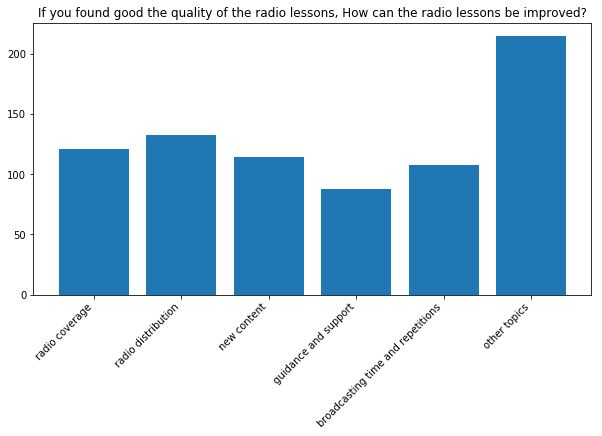

In [77]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_good_group.columns, radio_lessons_good_group.sum())
plt.title('If you found good the quality of the radio lessons, How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/radio_lessons_good.jpeg',bbox_inches='tight', dpi=300)
plt.show()

#### Trigram Vectorization
Radio Lessons Fair Quality

In [78]:
radio_lessons_fair_tri = bow_vectorization(data = radio_lessons_fair.dropna(),
                                          index = radio_lessons_fair.dropna().index,
                                          n_grams=(3, 3))

750 words in dictionary.


In [79]:
# radio_lessons_fair_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [80]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'provis', radio_lessons_fair_tri.columns)
print(len(coverage_1))

79


In [81]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'exten', radio_lessons_fair_tri.columns)
print(len(coverage_2))

75


In [82]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'avail', radio_lessons_fair_tri.columns)
print(len(coverage_3))

80


In [83]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'local', radio_lessons_fair_tri.columns)
print(len(coverage_4))

79


In [84]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

74

Trigrams about the provision of radios

In [85]:
power = search(['powe','energ'],None, radio_lessons_fair_tri.columns)
len(power)

6

In [86]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_fair_tri.columns)
len(provision)

102

In [87]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_fair_tri.columns)
len(tv)

8

Trigrams about content

In [88]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_fair_tri.columns)
len(content)

83

Trigrams about speech

In [89]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_fair_tri.columns)
len(language)

29

In [90]:
speed = search(['speed','unders'], None, radio_lessons_fair_tri.columns)
len(speed)

23

Trigrams about teaching

In [91]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_fair_tri.columns)
len(teaching)

102

Tigrams about school re-opening

In [92]:
school = search(['reopen', 'open'], None, radio_lessons_fair_tri.columns)
len(school)

37

Tigrams about time (to listen, of broadcast)

In [93]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_fair_tri.columns)
len(time)

94

Don't Know (DK)

In [94]:
dk = search(["don't", 'idea', 'nothing'], None, radio_lessons_fair_tri.columns)
len(dk)

2

Count one per concept apperance (not word)

In [95]:
cover = radio_lessons_fair_tri[coverage]

In [96]:
r_provision = radio_lessons_fair_tri[list(set(power + provision + tv))]

In [97]:
l_content = radio_lessons_fair_tri[content]

In [98]:
#teach = radio_lessons_good_tri[teaching]

In [99]:
r_time = radio_lessons_fair_tri[time]

In [100]:
#l_speech = radio_lessons_good_tri[list(set(language +  speed))]

In [101]:
guidance = radio_lessons_fair_tri[list(set(language +  speed + teaching))]

The rest of the Trigrams

In [102]:
other = radio_lessons_fair_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)

In [103]:
test_other = radio_lessons_fair_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)
len(test_other.columns.to_list())

359

In [104]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
guidance = guidance.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
other = other.sum(axis=1)

In [105]:
cover[cover != 0] = 1
content[content != 0] = 1
guidance[guidance != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
other[other != 0] = 1

In [106]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['new content'])
cont.loc[content[content == 1].index,:] = 1

guid = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and support'])
guid.loc[guidance[guidance == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['broadcasting time and repetitions'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other topics'])
other_w.loc[other[other == 1].index,:] = 1

In [107]:
radio_lessons_fair_group = pd.concat([coverage, prov, cont, guid, timing, other_w], axis=1)
radio_lessons_fair_group_2 = pd.concat([coverage, prov, cont, guid, timing], axis=1)

Visualization

In [108]:
labels = radio_lessons_fair_group_2.columns.to_list()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=radio_lessons_fair_group_2.sum().to_list(),
    text=radio_lessons_fair_group_2.sum().to_list(),
    texttemplate='%{text}',
    textposition="outside",
    textangle=0,
    textfont_color="black",
))

fig.update_traces(textfont_size=18)
fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                      font=dict(
                        size=18,
                    ),
                  title_text='If you found fair the quality of the radio lessons,<br>How can the radio lessons be improved?')
pio.write_image(fig, 'plotly/radio_lessons_fair_group.jpg', width=1024, height=780)

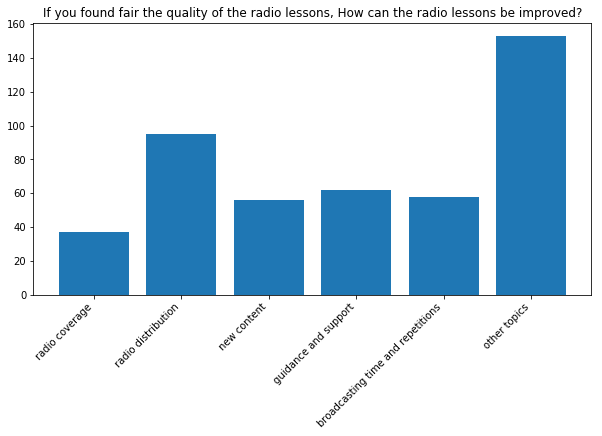

In [109]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_fair_group.columns, radio_lessons_fair_group.sum())
plt.title('If you found fair the quality of the radio lessons, How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/radio_lessons_fair.jpeg',bbox_inches='tight', dpi=300)
plt.show()

#### Trigram Vectorization
Radio Lessons Very Good Quality

In [110]:
radio_lessons_vgood_tri = bow_vectorization(data = radio_lessons_vgood.dropna(),
                                          index = radio_lessons_vgood.dropna().index,
                                          n_grams=(3, 3))

300 words in dictionary.


In [111]:
# radio_lessons_fair_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [112]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'provis', radio_lessons_vgood_tri.columns)
print(len(coverage_1))

30


In [113]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'exten', radio_lessons_vgood_tri.columns)
print(len(coverage_2))

25


In [114]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'avail', radio_lessons_vgood_tri.columns)
print(len(coverage_3))

30


In [115]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'local', radio_lessons_vgood_tri.columns)
print(len(coverage_4))

31


In [116]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

26

Trigrams about the provision of radios

In [117]:
power = search(['powe','energ'],None, radio_lessons_vgood_tri.columns)
len(power)

4

In [118]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_vgood_tri.columns)
len(provision)

23

In [119]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_vgood_tri.columns)
len(tv)

0

Trigrams about content

In [120]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_vgood_tri.columns)
len(content)

58

Trigrams about speech

In [121]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_vgood_tri.columns)
len(language)

9

In [122]:
speed = search(['speed','unders'], None, radio_lessons_vgood_tri.columns)
len(speed)

6

Trigrams about teaching

In [123]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_vgood_tri.columns)
len(teaching)

49

Tigrams about school re-opening

In [124]:
school = search(['reopen', 'open'], None, radio_lessons_vgood_tri.columns)
len(school)

6

Tigrams about time (to listen, of broadcast)

In [125]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_vgood_tri.columns)
len(time)

54

Count one per concept apperance (not word)

In [126]:
cover = radio_lessons_vgood_tri[coverage]

In [127]:
r_provision = radio_lessons_vgood_tri[list(set(power + provision + tv))]

In [128]:
l_content = radio_lessons_vgood_tri[content]

In [129]:
#teach = radio_lessons_good_tri[teaching]

In [130]:
r_time = radio_lessons_vgood_tri[time]

In [131]:
#l_speech = radio_lessons_good_tri[list(set(language +  speed))]

In [132]:
guidance = radio_lessons_vgood_tri[list(set(language +  speed + teaching))]

The rest of the Trigrams

In [133]:
other = radio_lessons_vgood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)

In [134]:
test_other = radio_lessons_vgood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)
len(test_other.columns.to_list())

150

In [135]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
guidance = guidance.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
other = other.sum(axis=1)

In [136]:
cover[cover != 0] = 1
content[content != 0] = 1
guidance[guidance != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
other[other != 0] = 1

In [137]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['new content'])
cont.loc[content[content == 1].index,:] = 1

guid = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and support'])
guid.loc[guidance[guidance == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['broadcasting time and repetitions'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other topics'])
other_w.loc[other[other == 1].index,:] = 1

In [138]:
radio_lessons_vgood_group = pd.concat([coverage, prov, cont, guid, timing, other_w], axis=1)
radio_lessons_vgood_group_2 = pd.concat([coverage, prov, cont, guid, timing], axis=1)

Visualization

In [139]:
labels = radio_lessons_vgood_group_2.columns.to_list()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=radio_lessons_vgood_group_2.sum().to_list(),
    text=radio_lessons_vgood_group_2.sum().to_list(),
    texttemplate='%{text}',
    textposition="outside",
    textangle=0,
    textfont_color="black",
))

fig.update_traces(textfont_size=18)
fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                      font=dict(
                        size=18,
                    ),
                  title_text='If you found very good the quality of the radio lessons,<br>How can the radio lessons be improved?')
pio.write_image(fig, 'plotly/radio_lessons_vgood_group.jpg', width=1024, height=780)

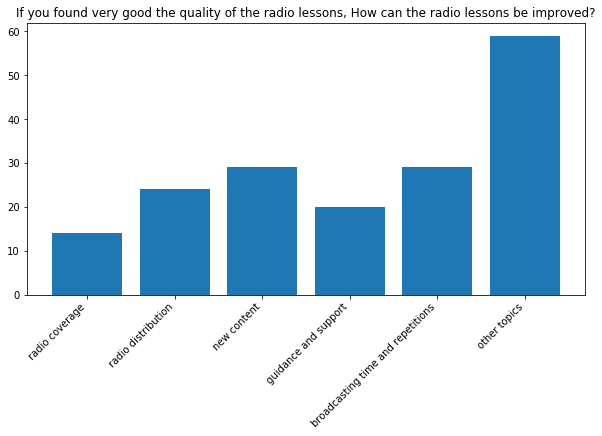

In [140]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_vgood_group.columns, radio_lessons_vgood_group.sum())
plt.title('If you found very good the quality of the radio lessons, How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/radio_lessons_vgood.jpeg',bbox_inches='tight', dpi=300)
plt.show()

#### Trigram Vectorization
Radio Lessons No Good Quality

In [141]:
radio_lessons_ngood_tri = bow_vectorization(data = radio_lessons_ngood.dropna(),
                                          index = radio_lessons_ngood.dropna().index,
                                          n_grams=(3, 3))

389 words in dictionary.


In [142]:
# radio_lessons_fair_tri.sum().sort_values(ascending=False)[:30]

#### Group Trigrams
Trigrams about the coverage

In [143]:
coverage_1 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'provis', radio_lessons_ngood_tri.columns)
print(len(coverage_1))

50


In [144]:
coverage_2 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'exten', radio_lessons_ngood_tri.columns)
print(len(coverage_2))

49


In [145]:
coverage_3 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'avail', radio_lessons_ngood_tri.columns)
print(len(coverage_3))

50


In [146]:
coverage_4 = search(['area','cover','extension','tune','network','station','access','rural','fm','power'], \
                  'local', radio_lessons_ngood_tri.columns)
print(len(coverage_4))

49


In [147]:
coverage = list(set(coverage_1 + coverage_2 + coverage_3 + coverage_4))
len(coverage)

46

Trigrams about the provision of radios

In [148]:
power = search(['powe','energ'],None, radio_lessons_ngood_tri.columns)
len(power)

6

In [149]:
provision = search(['provis','dist','provid','everyone'], None, radio_lessons_ngood_tri.columns)
len(provision)

46

In [150]:
tv = search(['video', 'tv', 'tele'], None, radio_lessons_ngood_tri.columns)
len(tv)

12

Trigrams about content

In [151]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_ngood_tri.columns)
len(content)

60

Trigrams about speech

In [152]:
language = search(['language','trans','arab', 'pronunc'], None, radio_lessons_ngood_tri.columns)
len(language)

12

In [153]:
speed = search(['speed','unders'], None, radio_lessons_ngood_tri.columns)
len(speed)

6

Trigrams about teaching

In [154]:
teaching = search(['guide', 'support', 'teacher', 'follow', 'expla', 'slow', 'question'], None, radio_lessons_ngood_tri.columns)
len(teaching)

57

Tigrams about school re-opening

In [155]:
school = search(['reopen', 'open'], None, radio_lessons_ngood_tri.columns)
len(school)

47

Tigrams about time (to listen, of broadcast)

In [156]:
time = search(['time', 'repeat', 'timing', 'tmie', 'freq'], None, radio_lessons_ngood_tri.columns)
len(time)

65

Count one per concept apperance (not word)

In [157]:
cover = radio_lessons_ngood_tri[coverage]

In [158]:
r_provision = radio_lessons_ngood_tri[list(set(power + provision + tv))]

In [159]:
l_content = radio_lessons_ngood_tri[content]

In [160]:
#teach = radio_lessons_good_tri[teaching]

In [161]:
r_time = radio_lessons_ngood_tri[time]

In [162]:
#l_speech = radio_lessons_good_tri[list(set(language +  speed))]

In [163]:
guidance = radio_lessons_ngood_tri[list(set(language +  speed + teaching))]

The rest of the Trigrams

In [164]:
other = radio_lessons_ngood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)

In [165]:
test_other = radio_lessons_ngood_tri.drop(cover.columns.to_list() + \
                                    l_content.columns.to_list() + \
                                    r_provision.columns.to_list() + \
                                    r_time.columns.to_list() + \
                                    guidance.columns.to_list(), axis=1)
len(test_other.columns.to_list())

181

In [166]:
cover = cover.sum(axis=1)
content = l_content.sum(axis=1)
guidance = guidance.sum(axis=1)
time = r_time.sum(axis=1)
provision = r_provision.sum(axis=1)
other = other.sum(axis=1)

In [167]:
cover[cover != 0] = 1
content[content != 0] = 1
guidance[guidance != 0] = 1
time[time != 0] = 1
provision[provision != 0] = 1
other[other != 0] = 1

In [168]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio coverage'])
coverage.loc[cover[cover == 1].index,:] = 1

prov = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['radio distribution'])
prov.loc[provision[provision == 1].index,:] = 1

cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['new content'])
cont.loc[content[content == 1].index,:] = 1

guid = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['guidance and support'])
guid.loc[guidance[guidance == 1].index,:] = 1

timing = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['broadcasting time and repetitions'])
timing.loc[time[time == 1].index,:] = 1

other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other topics'])
other_w.loc[other[other == 1].index,:] = 1

In [169]:
radio_lessons_ngood_group = pd.concat([coverage, prov, cont, guid, timing, other_w], axis=1)
radio_lessons_ngood_group_2 = pd.concat([coverage, prov, cont, guid, timing], axis=1)

Visualization

In [170]:
labels = radio_lessons_ngood_group_2.columns.to_list()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=radio_lessons_ngood_group_2.sum().to_list(),
    text=radio_lessons_ngood_group_2.sum().to_list(),
    texttemplate='%{text}',
    textposition="outside",
    textangle=0,
    textfont_color="black",
))

fig.update_traces(textfont_size=18)
fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                      font=dict(
                        size=18,
                    ),
                  title_text='If you did not find good the quality of the radio lessons,<br>How can the radio lessons be improved?')
pio.write_image(fig, 'plotly/radio_lessons_ngood_group.jpg', width=1024, height=780)

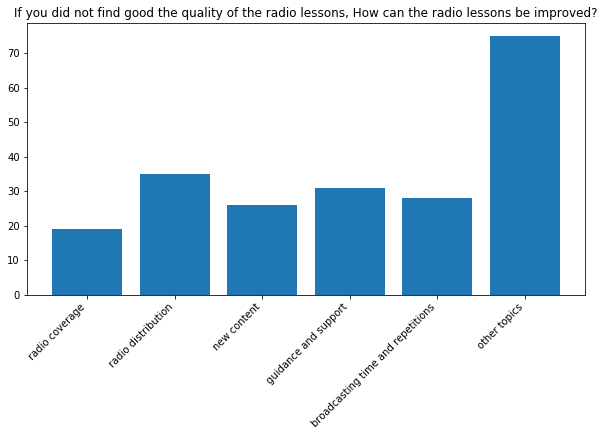

In [171]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_ngood_group.columns, radio_lessons_ngood_group.sum())
plt.title('If you did not find good the quality of the radio lessons, How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.savefig('data/imgs/radio_lessons_ngood.jpeg',bbox_inches='tight', dpi=300)
plt.show()

#### Save vectors and concepts

In [172]:
radio_lessons_good_group.to_csv('data/concepts/radio_lessons_good_concepts.csv')
radio_lessons_fair_group.to_csv('data/concepts/radio_lessons_fair_concepts.csv')

radio_lessons_vgood_group.to_csv('data/concepts/radio_lessons_vgood_concepts.csv')
radio_lessons_ngood_group.to_csv('data/concepts/radio_lessons_ngood_concepts.csv')

In [173]:
radio_lessons_good_tri.to_csv('data/tokens/radio_lessons_good.csv')
radio_lessons_fair_tri.to_csv('data/tokens/radio_lessons_fair.csv')

radio_lessons_vgood_tri.to_csv('data/tokens/radio_lessons_vgood.csv')
radio_lessons_ngood_tri.to_csv('data/tokens/radio_lessons_ngood.csv')

In [174]:
np.round((radio_lessons_good_group.iloc[:,:-1].sum() / radio_lessons_good.shape[0])*100,1).to_list()

[19.5, 21.4, 18.4, 14.2, 17.4]

### Versus

In [175]:
ag = radio_lessons_good.shape[0]
avg= radio_lessons_vgood.shape[0]
ang = radio_lessons_ngood.shape[0]
af = radio_lessons_fair.shape[0]

In [176]:
labels = radio_lessons_vgood_group.columns.to_list()

vgood = radio_lessons_vgood_group.iloc[:,:-1].sum().to_list()
good = radio_lessons_good_group.iloc[:,:-1].sum().to_list()
fair = radio_lessons_fair_group.iloc[:,:-1].sum().to_list()
ngood = radio_lessons_ngood_group.iloc[:,:-1].sum().to_list()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=vgood,
    text=vgood,
    name=f'Very Good Quality',
    texttemplate='%{text}',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))
fig.add_trace(go.Bar(
    x=labels,
    y=good,
    name=f'Good Radio Quality',
    text=good,
    texttemplate='%{text}',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))
fig.add_trace(go.Bar(
    x=labels,
    y=fair,
    name=f'Fair Radio Quality',
    text=fair,
    texttemplate='%{text}',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))
fig.add_trace(go.Bar(
    x=labels,
    y=ngood,
    name=f'No Good Radio Quality',
    text=ngood,
    texttemplate='%{text}',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))

fig.update_traces(textfont_size=18)
fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                  font=dict(
                      size=18,
                  ),
                  title_text='<b>How can the radio lessons be improved?</b><br>Topics per group of opinions')
#fig.write_html("data/file_2.html")
pio.write_image(fig, 'plotly/comparative.jpg', width=1024, height=780)

In [177]:
labels = radio_lessons_vgood_group.columns.to_list()

vgood = np.round((radio_lessons_vgood_group.iloc[:,:-1].sum() / radio_lessons_vgood.shape[0]*100),1).to_list()
good = np.round((radio_lessons_good_group.iloc[:,:-1].sum() / radio_lessons_good.shape[0]*100),1).to_list()
fair = np.round((radio_lessons_fair_group.iloc[:,:-1].sum() / radio_lessons_fair.shape[0]*100),1).to_list()
ngood = np.round((radio_lessons_ngood_group.iloc[:,:-1].sum() / radio_lessons_ngood.shape[0]*100),1).to_list()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=vgood,
    text=vgood,
    name='Very Good Quality',
    texttemplate='%{text:.2s}%',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))
fig.add_trace(go.Bar(
    x=labels,
    y=good,
    name='Good Radio Quality',
    text=good,
    texttemplate='%{text:.2s}%',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))
fig.add_trace(go.Bar(
    x=labels,
    y=fair,
    name='Fair Radio Quality',
    text=fair,
    texttemplate='%{text:.2s}%',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))
fig.add_trace(go.Bar(
    x=labels,
    y=ngood,
    name='No Good Radio Quality',
    text=ngood,
    texttemplate='%{text:.2s}%',
    textposition="inside",
    textangle=0,
    textfont_color="white",
))

fig.update_layout(barmode='group',
                  xaxis = dict(
                      tickfont=dict(size=18)
                  ),
                  title_text='<b>How can the radio lessons be improved?</b><br>Topics per group of opinions')
fig.write_html("data/file.html")
pio.write_image(fig, 'plotly/comparative_percent.jpg', width=1024, height=780)